In [0]:
!pip install mxnet-cu100

#MXNet (Using Gluon)

In [0]:
import mxnet as mx
from mxnet import nd, autograd, gluon
import matplotlib.pyplot as plt

mx.random.seed(1)

data_ctx = mx.cpu()
model_ctx = mx.gpu()

In [0]:
def transform(data, label):
    return data.astype('float32')/255.0, label.astype('float32')

train_mnist = gluon.data.vision.FashionMNIST(train = True, transform = transform)
test_mnist = gluon.data.vision.FashionMNIST(train = False, transform = transform)

In [0]:
classes = {0: 'T-shirt/top', 1: 'Trouser', 2: 'Pullover', 3: 'Dress', 4: 'Coat', 5: 'Sandal', 6: 'Shirt', 7: 'Sneaker', 8: 'Bag', 9: 'Ankle boot'}

In [0]:
image, label = train_mnist[798]
print(image.shape, label.shape)

(28, 28, 1) ()


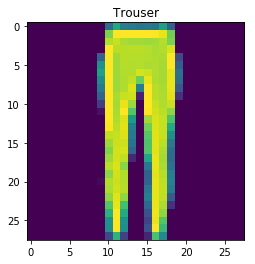

In [0]:
plt.imshow(image.reshape((28, 28)).asnumpy())
plt.title(classes[label])
plt.show()


##Creating data loader for training and testing

In [0]:
batch_size = 64
training_data = gluon.data.DataLoader(train_mnist, batch_size = batch_size, shuffle = True)
testing_data = gluon.data.DataLoader(test_mnist, batch_size = batch_size, shuffle = False)

#Building the model

In [0]:
# class neuralnetworks(gluon.Block):
#     def __init__(self, **kwargs):
#         super(neuralnetworks, self).__init__(**kwargs)
#         with self.name_scope():
#             self.dense1 = gluon.nn.Dense(256)
#             self.dense2 = gluon.nn.Dense(128)
#             self.dense3 = gluon.nn.Dense(10)
            
#     def forward(self, inputs):
#         layer1 = nd.relu(self.dense1(inputs))
#         layer2 = nd.relu(self.dense2(layer1))
#         predictions = nd.softmax(self.dense3(layer2))
#         return predictions

model = gluon.nn.Sequential('mymodel')
model.add(gluon.nn.Dense(256))
model.add(gluon.nn.Dense(128))
model.add(gluon.nn.Dense(10))

model.initialize(mx.init.Xavier(), model_ctx)

In [0]:
model(image.reshape((-1, 784)).as_in_context(model_ctx))


[[0.08143232 0.23256525 0.07915243 0.08072428 0.12125606 0.05625639
  0.06785643 0.04909085 0.10063601 0.13103002]]
<NDArray 1x10 @gpu(0)>

##Defining our objective loss

In [0]:
objective = gluon.loss.SoftmaxCrossEntropyLoss()

#Defining parameters optimizer

In [0]:
optimizer = gluon.Trainer(model.collect_params(), 'sgd', {'learning_rate': 0.01})

##Defining our accuracy function(this time we are using accuracy metric provided by gluon.)

In [0]:
metric = mx.metric.Accuracy()

##Training the model

In [0]:
epochs = 10
num_batches = 60000/batch_size
losses = []
accs = []

for epoch in range(epochs):
    cumulative_loss = 0
    metric.reset()
    for features, labels in training_data:
        features = features.as_in_context(model_ctx).reshape((-1, 784))
        labels = labels.as_in_context(model_ctx)
        with autograd.record():
            output = model(features)
            loss = objective(output, labels)
        loss.backward()
        optimizer.step(128)
        cumulative_loss += loss.mean()
        metric.update(labels, output)
    print(f'Epoch: {epoch} Loss: {cumulative_loss.asscalar()/num_batches} Accuracy: {metric.get()[1]}')
    losses.append(cumulative_loss.asscalar()/num_batches)
    accs.append(metric.get()[1])

Epoch: 0 Loss: 2.2024138020833335 Accuracy: 0.3435666666666667
Epoch: 1 Loss: 1.9851354166666666 Accuracy: 0.5489166666666667
Epoch: 2 Loss: 1.9004209635416667 Accuracy: 0.6133833333333333
Epoch: 3 Loss: 1.8641997395833334 Accuracy: 0.6286666666666667
Epoch: 4 Loss: 1.8495197916666666 Accuracy: 0.6309166666666667
Epoch: 5 Loss: 1.8355317708333334 Accuracy: 0.6407166666666667
Epoch: 6 Loss: 1.8159671875 Accuracy: 0.6809166666666666
Epoch: 7 Loss: 1.79713515625 Accuracy: 0.7017
Epoch: 8 Loss: 1.7831483072916667 Accuracy: 0.7110333333333333
Epoch: 9 Loss: 1.7731161458333333 Accuracy: 0.7163166666666667


In [0]:
metric.reset()
for features, labels in testing_data:
    predictions = model(features.as_in_context(model_ctx).reshape((-1, 784)))
    labels = labels.as_in_context(model_ctx)
    metric.update(labels, predictions)
print(f'Test Accuracy: {metric.get()[1]}')

Test Accuracy: 0.7161


In [0]:
def plot(losses = losses, accs = accs, model = model, samples = 5):
    plt.plot(losses, 'r')
    plt.title('Loss during Training')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()
    
    plt.plot(accs, 'g')
    plt.title('Accuracy during Training')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.show()
    
    for i, batch in enumerate(test_mnist):
        features = batch[0].as_in_context(model_ctx).reshape((1, 784))
        labels = batch[1]
        predictions = model(features).argmax(1).asscalar()
        plt.imshow(features.reshape((28, 28)).asnumpy())
        plt.title(f'Predicted: {classes[predictions]}, Target: {classes[labels]}')
        plt.show()
        if i == samples:
            break

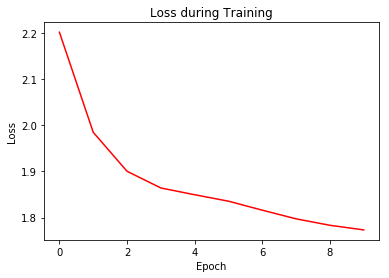

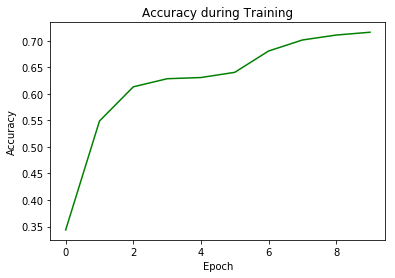

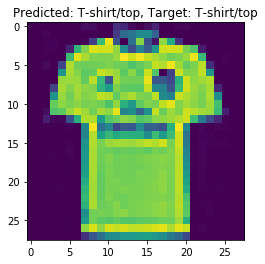

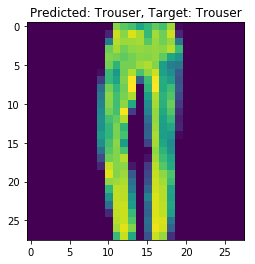

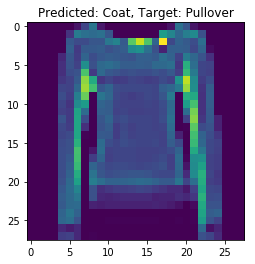

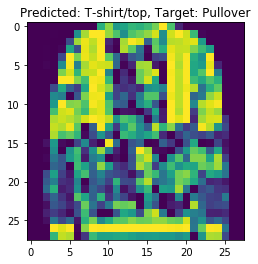

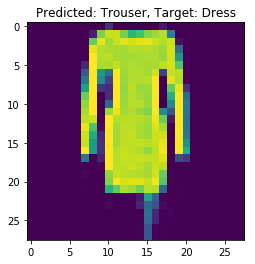

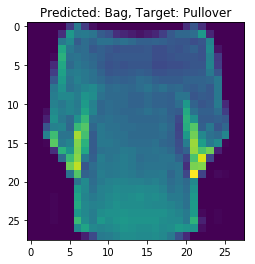

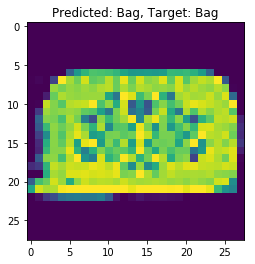

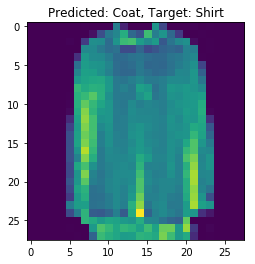

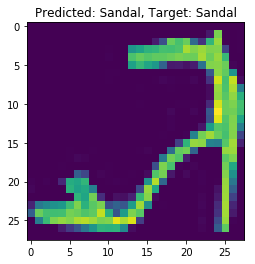

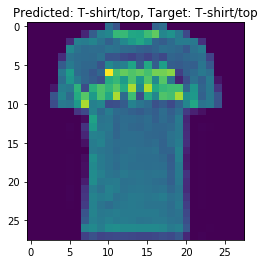

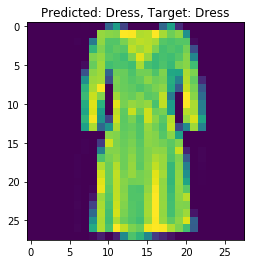

In [0]:
plot(samples = 10)